#Libraries and Data

In [33]:
#import libraries
import numpy as np
import pandas as pd
import itertools
from prophet import Prophet
import yfinance
import pickle


In [2]:
#load the data

data = yfinance.download (tickers = "TATAPOWER.NS",start="2000-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)

data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-06-22,224.850006,225.149994,220.500000,221.100006,6857007
2023-06-23,222.000000,222.100006,215.699997,218.300003,10890426
2023-06-26,218.300003,219.350006,216.300003,218.600006,5136478
2023-06-27,218.899994,220.500000,218.600006,219.250000,4694432
2023-06-28,219.949997,220.949997,217.550003,218.649994,8340649


#Data preparation

In [3]:
#transform the date variable
data["Data"] = pd.to_datetime(data.index, format = "%m/%d/%Y")
data.Data

Date
2000-03-06   2000-03-06
2000-03-07   2000-03-07
2000-03-08   2000-03-08
2000-03-09   2000-03-09
2000-03-10   2000-03-10
                ...    
2023-06-22   2023-06-22
2023-06-23   2023-06-23
2023-06-26   2023-06-26
2023-06-27   2023-06-27
2023-06-28   2023-06-28
Name: Data, Length: 5821, dtype: datetime64[ns]

In [4]:
#renaming variables
data = data.rename(columns = {'Close': 'y',
                     'Data': 'ds'})
data.head(10)

,Open,High,Low,y,Volume,ds
Date,,,,,,
2000-03-06,4.450512,4.528395,4.227986,4.280836,493866,2000-03-06
2000-03-07,4.280836,4.339248,4.008242,4.211296,759074,2000-03-07
2000-03-08,4.353157,4.428259,4.005460,4.019369,393941,2000-03-08
2000-03-09,4.005459,4.058309,3.922011,4.033275,489390,2000-03-09
2000-03-10,4.005460,4.144538,3.922013,3.958174,493006,2000-03-10
2000-03-13,3.844129,3.949829,3.671672,3.696706,247943,2000-03-13
2000-03-14,3.504778,3.782935,3.504778,3.746774,965402,2000-03-14
2000-03-15,3.833003,3.941484,3.727303,3.810750,368542,2000-03-15
2000-03-16,3.780153,3.805187,3.702270,3.727303,536052,2000-03-16


#Holidays

In [5]:
#Easter
#easter_dates = df[df.Easter == 1].ds
#easter = pd.DataFrame({'holiday': 'easter',
#                      'ds': pd.to_datetime(easter_dates),
#                      'lower_window': -5,
#                      'upper_window': 2})
#easter.head(2)

In [6]:
#Thanksgiving
#thanksgiving_dates = df[df.Thanksgiving == 1].ds
#thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
 #                      'ds': pd.to_datetime(thanksgiving_dates),
  #                     'lower_window': -5,
   #                    'upper_window': 2})
#thanksgiving.head(2)

In [7]:
#combining holidays
#holidays = pd.concat([easter, thanksgiving])
#holidays

In [8]:
#create training and test set
test_days = 2000
training_set = data.iloc[:-test_days,:]
test_set = data.iloc[-test_days:,:]

#Prophet

In [9]:
m = Prophet(
            #holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 20,
            changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(training_set)

13:45:55 - cmdstanpy - INFO - Chain [1] start processing
13:46:06 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
#create future df
future = m.make_future_dataframe(periods = test_days,
                                 freq = "D")

In [11]:
future = pd.concat([future], axis = 1)

In [12]:
#forecast
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
5816,2020-11-11,7.290245,-469.805053,561.290585,-67.435811,81.987309,5.899855,5.899855,5.899855,5.870651,5.870651,5.870651,0.029203,0.029203,0.029203,0.0,0.0,0.0,50.301629
5817,2020-11-12,7.289064,-466.308128,564.292656,-67.473305,82.113463,5.895623,5.895623,5.895623,5.878510,5.878510,5.878510,0.017113,0.017113,0.017113,0.0,0.0,0.0,50.262636
5818,2020-11-13,7.287884,-469.217091,568.738580,-67.519703,82.239617,5.874943,5.874943,5.874943,5.869123,5.869123,5.869123,0.005821,0.005821,0.005821,0.0,0.0,0.0,50.103788
5819,2020-11-14,7.286703,-1126.855708,926.923222,-67.574324,82.365198,-14.678555,-14.678555,-14.678555,-14.673993,-14.673993,-14.673993,-0.004562,-0.004562,-0.004562,0.0,0.0,0.0,-99.671573
5820,2020-11-15,7.285523,-1119.098194,929.568493,-67.628944,82.488815,-14.687940,-14.687940,-14.687940,-14.673988,-14.673988,-14.673988,-0.013951,-0.013951,-0.013951,0.0,0.0,0.0,-99.723793


In [13]:
data = data.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
data

,Date,Open,High,Low,y,Volume,ds
0,2000-03-06,4.450512,4.528395,4.227986,4.280836,493866,2000-03-06
1,2000-03-07,4.280836,4.339248,4.008242,4.211296,759074,2000-03-07
2,2000-03-08,4.353157,4.428259,4.005460,4.019369,393941,2000-03-08
3,2000-03-09,4.005459,4.058309,3.922011,4.033275,489390,2000-03-09
4,2000-03-10,4.005460,4.144538,3.922013,3.958174,493006,2000-03-10
...,...,...,...,...,...,...,...
5816,2023-06-22,224.850006,225.149994,220.500000,221.100006,6857007,2023-06-22
5817,2023-06-23,222.000000,222.100006,215.699997,218.300003,10890426,2023-06-23
5818,2023-06-26,218.300003,219.350006,216.300003,218.600006,5136478,2023-06-26
5819,2023-06-27,218.899994,220.500000,218.600006,219.250000,4694432,2023-06-27


In [14]:
#get some variables
prophet_variables = forecast.loc[:, ["trend", "weekly",  "multiplicative_terms"]]
df_xgb = pd.concat([data, prophet_variables], axis = 1)
df_xgb.head(1)

,Date,Open,High,Low,y,Volume,ds,trend,weekly,multiplicative_terms
0,2000-03-06,4.450512,4.528395,4.227986,4.280836,493866,2000-03-06,0.45701,5.876794,5.690522


#XGBoost preparation

In [15]:
#create training and test set
test_days = 100
training_set = df_xgb.iloc[:-test_days,:]
test_set = df_xgb.iloc[-test_days:,:]

In [16]:
#isolate X and y
y_train = training_set.y
y_test = test_set.y 
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [17]:
X_train = X_train.drop(columns=["ds"])
X_test = X_test.drop(columns=["ds"])


In [18]:
#Matrices
import xgboost as xgb
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

In [19]:
#set the parameters
parameters = {'learning_rate': 0.3,
              'max_depth': 6,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight' : 1,
              'gamma': 0,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

#XGBoost

In [20]:
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 40,
                  evals = [(Test, "y")])

[0]	y-rmse:137.88615
[1]	y-rmse:96.44007
[2]	y-rmse:67.80927
[3]	y-rmse:47.45825
[4]	y-rmse:33.00327
[5]	y-rmse:23.34675
[6]	y-rmse:16.36136
[7]	y-rmse:11.53651
[8]	y-rmse:8.56421
[9]	y-rmse:7.19553
[10]	y-rmse:5.95740
[11]	y-rmse:5.11811
[12]	y-rmse:4.40659
[13]	y-rmse:3.78623
[14]	y-rmse:3.54831
[15]	y-rmse:3.30384
[16]	y-rmse:3.20261
[17]	y-rmse:3.13747
[18]	y-rmse:2.97729
[19]	y-rmse:2.95024
[20]	y-rmse:2.92357
[21]	y-rmse:2.90294
[22]	y-rmse:2.89143
[23]	y-rmse:2.87357
[24]	y-rmse:2.86973
[25]	y-rmse:2.86744
[26]	y-rmse:2.78604
[27]	y-rmse:2.78224
[28]	y-rmse:2.78188
[29]	y-rmse:2.77216
[30]	y-rmse:2.76994
[31]	y-rmse:2.77762
[32]	y-rmse:2.78046
[33]	y-rmse:2.77950
[34]	y-rmse:2.77937
[35]	y-rmse:2.77773
[36]	y-rmse:2.77813
[37]	y-rmse:2.78129
[38]	y-rmse:2.78176
[39]	y-rmse:2.73511


In [39]:
model_path = 'prophet_model.pkl'
# Save the model to the specified path
with open(model_path, 'wb') as f:
    print(f)
    pickle.dump(model, f)

<_io.BufferedWriter name='prophet_model.pkl'>


In [41]:
with open('prophet_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    print(loaded_model)


In [37]:
#f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
#f_predictions


['/bin/bash: -c: line 1: syntax error: unexpected end of file']


In [24]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

#VIZ and assessment

In [25]:
#Visualization
training_set.index = training_set.ds
test_set.index = test_set.ds

<Axes: xlabel='ds'>

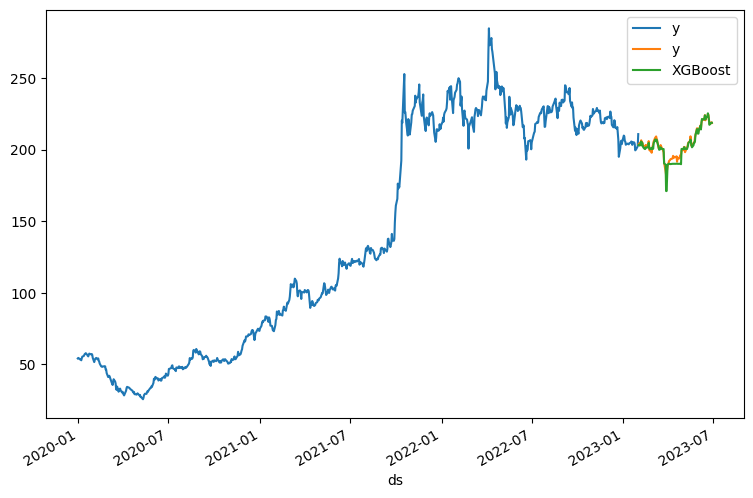

In [26]:
training_set.y['2020-01-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions.plot(legend = True)

In [27]:
#MAPE
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set.y, predictions)

0.8678856943128023

#Future



In [28]:
# Create a dictionary with data
data = {
            'High': [4.123123],
    'Low': [4.123123],
    'y': [210.935516],
    'Volume': [4.123123],
        'trend': [8.12313],
        'weekly': [4.123123],
            'multiplicative_terms': [4.444],
                

                
                }

# Create a new DataFrame object
df = pd.DataFrame(data)


In [29]:
Future = xgb.DMatrix(df, label = df.y)
f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
f_predictions

0    153.933731
Name: XGBoost, dtype: float32